In [2]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [3]:
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

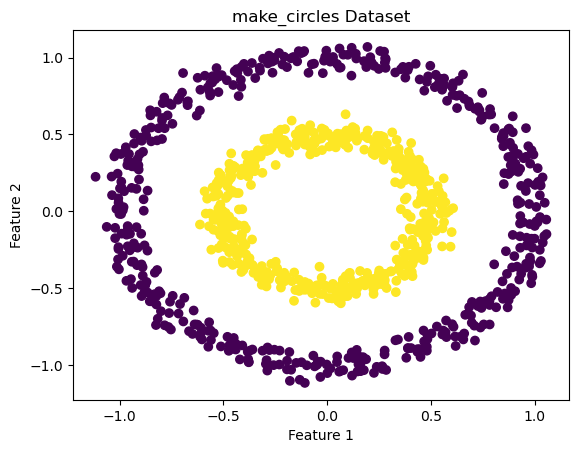

In [4]:
# Plot the generated data
plt.scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis')
plt.title("make_circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [5]:
moon_df = pd.DataFrame({"X": X_circles[:,0],"Y":  X_circles[:,1],"label": y_circles })
moon_df

,X,Y,label
0,0.452592,0.168433,1
1,-0.438027,0.119900,1
2,-0.532224,0.184359,1
3,-0.301402,0.400782,1
4,0.445602,-0.894936,0
...,...,...,...
995,0.249091,0.925787,0
996,-0.985370,-0.288162,0
997,-0.072016,-0.531447,1
998,0.660905,-0.793190,0


In [6]:
torch.__version__

'2.6.0+cpu'

In [7]:
X = torch.from_numpy(X_circles).type(torch.float)
y = torch.from_numpy(y_circles).type(torch.float)

In [8]:
# train_test_split of the data
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [9]:
print(f""" 
      input Values: {X_train[:5]}
      output_label: {y_train[:5]}
      
      """)

 
      input Values: tensor([[ 0.4413, -0.2603],
        [ 0.6030, -0.7328],
        [-1.0219, -0.1066],
        [-0.9613, -0.2265],
        [-0.1010,  0.5180]])
      output_label: tensor([1., 0., 0., 0., 1.])
      
      


In [10]:
len(X_train),len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [11]:
type(X_train),X_train.dtype, X_train.device, X_train.requires_grad

(torch.Tensor, torch.float32, device(type='cpu'), False)

In [12]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.linear1 = nn.Linear(in_features=2, out_features=10)
        self.linear2 = nn.Linear(in_features= 10, out_features= 1)
        self.sigmoid = nn.Sigmoid()
        self.relu= nn.ReLU()
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        x = self.linear1(x)
        x= self.linear2(x)
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return x  
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [13]:
model = NeuralNetworkClassification().to(device)
model

NeuralNetworkClassification(
  (linear1): Linear(in_features=2, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

In [14]:
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.3578,  0.4555],
                      [ 0.5400,  0.4482],
                      [-0.5659,  0.3127],
                      [-0.5627, -0.4487],
                      [-0.2268, -0.1326],
                      [-0.4317, -0.0763],
                      [ 0.6904,  0.7022],
                      [-0.3120,  0.4008],
                      [ 0.3951,  0.1650],
                      [-0.5820,  0.1132]])),
             ('linear1.bias',
              tensor([-0.4185, -0.0911,  0.1589, -0.0917, -0.6040, -0.2685, -0.2025,  0.2619,
                      -0.6272,  0.1591])),
             ('linear2.weight',
              tensor([[-0.0612, -0.0005,  0.3159,  0.0489, -0.2817,  0.0076,  0.1187,  0.1197,
                        0.1848,  0.2402]])),
             ('linear2.bias', tensor([-0.1540]))])

In [15]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters())

In [16]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_test)[:5]

y_logits

tensor([[ 0.1597],
        [ 0.2629],
        [ 0.0262],
        [ 0.3217],
        [-0.1648]])

In [17]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [18]:
y_pred_test= torch.round(torch.sigmoid(y_logits))
y_pred_test.squeeze()

tensor([1., 1., 1., 1., 0.])

### Training and Testing loop 

In [19]:
def accuracy(y_pred, y_true):
    # TP + FP/ TP+FP +FN + FP
   return ((torch.eq(y_pred,y_true).sum())/len(y_true)) *100

In [20]:
# putting the data into device according 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_test.device)

cpu


In [21]:
# training and testing loop 
torch.manual_seed(42)
epochs = 300

for epoch in range(epochs):
    model.train()
    
    # forward pass 
    y_logits = model(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 10 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.69564 accuracy: 51.75 |  Test loss: 0.70184 Test Accuracy: 52.00 
Epoch: 10 Loss: 0.69563 accuracy: 51.75 |  Test loss: 0.70183 Test Accuracy: 52.00 
Epoch: 20 Loss: 0.69563 accuracy: 51.75 |  Test loss: 0.70182 Test Accuracy: 52.00 
Epoch: 30 Loss: 0.69562 accuracy: 51.75 |  Test loss: 0.70181 Test Accuracy: 52.00 
Epoch: 40 Loss: 0.69561 accuracy: 51.75 |  Test loss: 0.70180 Test Accuracy: 52.00 
Epoch: 50 Loss: 0.69561 accuracy: 51.75 |  Test loss: 0.70179 Test Accuracy: 52.00 
Epoch: 60 Loss: 0.69560 accuracy: 51.62 |  Test loss: 0.70178 Test Accuracy: 52.00 
Epoch: 70 Loss: 0.69559 accuracy: 51.62 |  Test loss: 0.70177 Test Accuracy: 52.00 
Epoch: 80 Loss: 0.69559 accuracy: 51.62 |  Test loss: 0.70177 Test Accuracy: 52.00 
Epoch: 90 Loss: 0.69558 accuracy: 51.62 |  Test loss: 0.70176 Test Accuracy: 52.00 
Epoch: 100 Loss: 0.69557 accuracy: 51.62 |  Test loss: 0.70175 Test Accuracy: 52.00 
Epoch: 110 Loss: 0.69557 accuracy: 51.62 |  Test loss: 0.70174 Test Accuracy

In [22]:
from helper_function import plot_decision_boundary

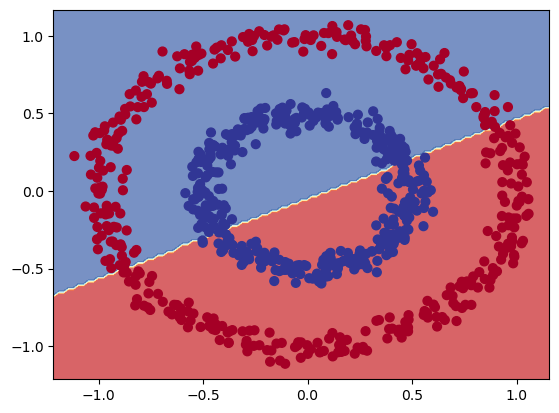

In [23]:
plot_decision_boundary(model,X_train,y_train)

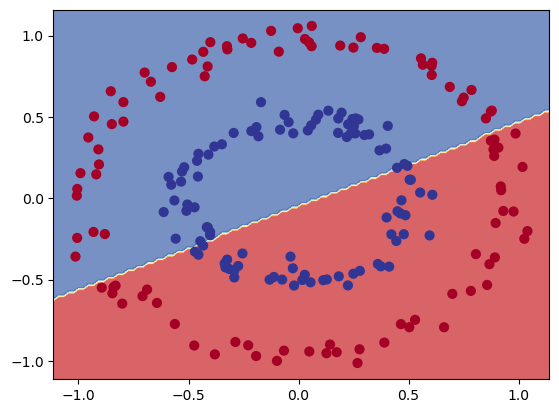

In [24]:
plot_decision_boundary(model,X_test,y_test)

In [25]:
# building model 
device = "cuda" if torch.cuda.is_available() else "cpu"


class NeuralNetworkClassification2(nn.Module):
    """docstring for ."""
    def __init__(self):
        super().__init__()
        # define all the layers of the models
        self.sequential = nn.Sequential( 
                                        nn.Linear(in_features=2, out_features=10),
                                        nn.ReLU(),
                                        nn.Linear(in_features=10, out_features=10),
                                        nn.ReLU(),
                                        # nn.Dropout(p=0.5),
                                        nn.Linear(in_features=10, out_features=1),
                                        )
     
        
        # using sequentail method
        # self.sequential_layer = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    
    def forward(self,x):
        
        # we used nn.BCEWithLogitsLoss (which is the combination of Sigmoid and BCELoss) so we don't need to sigmoid here
        # output = self.sigmoid(x)
        return self.sequential(x) 
        
        # sequentail method 
        # return self.sequential_layer(x)

    

In [26]:
model2 = NeuralNetworkClassification2()


In [27]:
# loss and optimizer for the classification problem
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(),lr=0.1)

In [28]:
# training and testing loop 
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model2.train()
    
    # forward pass 
    y_logits = model2(X_train).squeeze() # this are the logits without pass it from the activation function we have used the BCEWithLogits
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. calculate the loss and Accuracy of the model
    loss = loss_fn(y_logits,y_train) # we are using BCEWithLogitsLoss expects raw logits as input
    
    acc = accuracy(y_pred , y_train)
    
    
    # backpropagation 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # testing loop 
    
    model2.eval()
    with torch.inference_mode():
        y_test_logits = model2(X_test).squeeze()
        
        test_loss = loss_fn(y_test_logits,y_test)
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        
        test_acc = accuracy(y_test_pred , y_test)
        
        
    if epoch % 100 == 0:
            print(f"Epoch: {epoch} Loss: {loss:.5f} accuracy: {acc:.2f} |  Test loss: {test_loss:.5f} Test Accuracy: {test_acc:.2f} ")
    
    
    
    

Epoch: 0 Loss: 0.69355 accuracy: 50.00 |  Test loss: 0.69369 Test Accuracy: 50.00 
Epoch: 100 Loss: 0.68407 accuracy: 62.63 |  Test loss: 0.68381 Test Accuracy: 62.50 
Epoch: 200 Loss: 0.66352 accuracy: 67.12 |  Test loss: 0.66286 Test Accuracy: 69.00 
Epoch: 300 Loss: 0.61055 accuracy: 79.00 |  Test loss: 0.60784 Test Accuracy: 78.00 
Epoch: 400 Loss: 0.49171 accuracy: 88.62 |  Test loss: 0.48806 Test Accuracy: 90.50 
Epoch: 500 Loss: 0.26501 accuracy: 99.25 |  Test loss: 0.27231 Test Accuracy: 98.50 
Epoch: 600 Loss: 0.11323 accuracy: 100.00 |  Test loss: 0.12594 Test Accuracy: 100.00 
Epoch: 700 Loss: 0.05776 accuracy: 100.00 |  Test loss: 0.06913 Test Accuracy: 100.00 
Epoch: 800 Loss: 0.03497 accuracy: 100.00 |  Test loss: 0.04447 Test Accuracy: 100.00 
Epoch: 900 Loss: 0.02387 accuracy: 100.00 |  Test loss: 0.03173 Test Accuracy: 100.00 


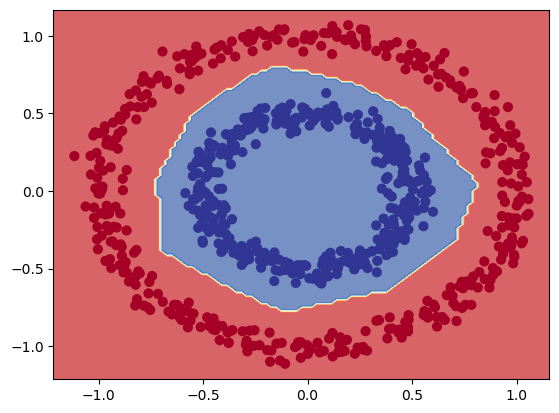

In [29]:
plot_decision_boundary(model2,X_train,y_train)

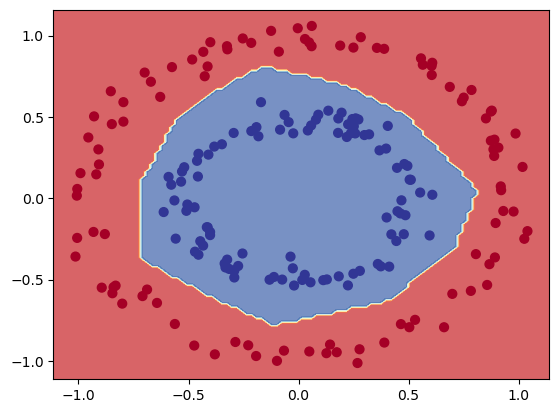

In [31]:
plot_decision_boundary(model2,X_test,y_test)